In [1]:
import numpy as np
import uproot
import matplotlib.pyplot as plt
from scipy import integrate
import AnaUtils as au
import Triggered as tr
import glob
import os

In [2]:
pmt = "KA0193"
wdir = '/data/share/'+pmt
fWaves = [os.path.splitext(iF)[0] for iF in glob.glob('{}/Gain/*.bin'.format(wdir))]
fWaves.sort() 
Gains = np.array([float(iF.split('/')[-1].split('V')[0]) for iF in fWaves])
nGains = len(Gains)
print(Gains,fWaves,nGains)

[1350. 1375. 1400. 1450. 1475. 1500. 1525. 1550.] ['/data/share/KA0193/Gain/1350V_200707_100_samples_30000_events', '/data/share/KA0193/Gain/1375V_200707_100_samples_30000_events', '/data/share/KA0193/Gain/1400V_200707_100_samples_30000_events', '/data/share/KA0193/Gain/1450V_200707_100_samples_30000_events', '/data/share/KA0193/Gain/1475V_200707_100_samples_30000_events', '/data/share/KA0193/Gain/1500V_200707_100_samples_30000_events', '/data/share/KA0193/Gain/1525V_200707_100_samples_30000_events', '/data/share/KA0193/Gain/1550V_200707_100_samples_30000_events'] 8


[-1.89812533e-02  2.13880146e+01  2.17096167e-01  1.28485680e+00
  6.80139425e+00  1.00652563e+00]
[-1.33869326e-02  1.64332324e+01  2.09095079e-01  1.48681509e+00
  4.40154059e+00  1.16243297e+00]
[-0.01934233 15.10992117 -0.21379758  1.66809429  3.61175169  1.32410816]
[-4.00882244e-05  2.26165330e+01  2.24217056e-01  2.21299822e+00
  4.50801997e+00  1.67164483e+00]
[4.14302038e-03 1.80759096e+01 2.22996920e-01 2.52327423e+00
 3.19744073e+00 1.81180029e+00]
[1.53855350e-03 2.39883806e+01 2.28459614e-01 2.83887791e+00
 3.79000606e+00 2.12995644e+00]
[2.32255069e-04 2.48036618e+01 2.37377325e-01 3.25417408e+00
 3.64146097e+00 2.47727659e+00]
[4.96651509e-03 3.06535705e+01 2.47187260e-01 3.66399401e+00
 4.18203597e+00 2.73573577e+00]


(array([1350., 1375., 1400., 1450., 1475., 1500., 1525., 1550.]),
 array([1.2848568 , 1.48681509, 1.66809429, 2.21299822, 2.52327423,
        2.83887791, 3.25417408, 3.66399401]),
 array([0.02928283, 0.03554929, 0.04248296, 0.05366353, 0.05420209,
        0.06587532, 0.08306552, 0.08379367]))

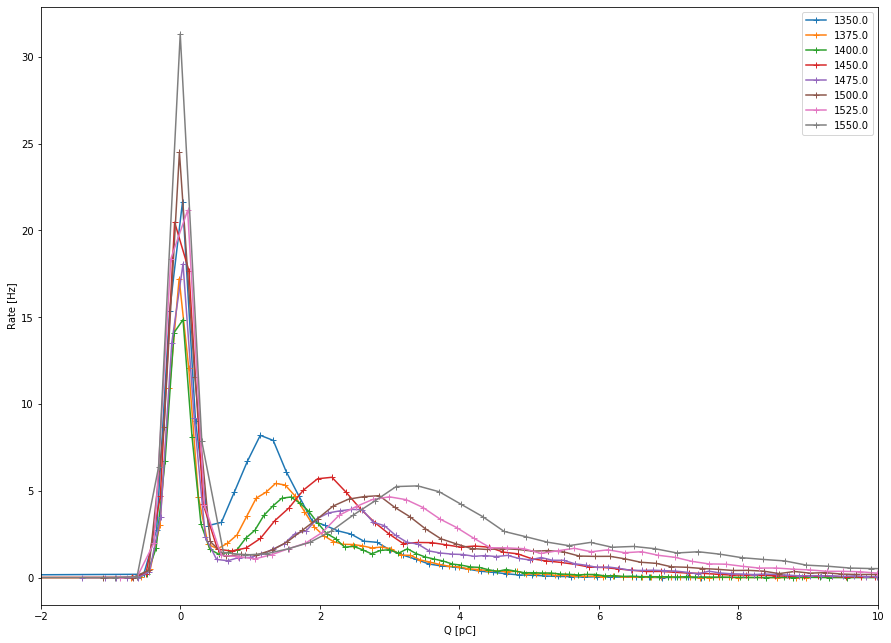

In [3]:
QHists = [tr.extRun(iG,30,3,6,qbins=100,plot=False) for iG in fWaves]
QSPE = np.array([0.]*nGains)
QErr = np.array([0.]*nGains)
for iq in range(nGains):
    #plt.plot(QHists[iq][1],QHists[iq][2],marker='x',label=Gains[iq])
    args = QHists[iq][3]
    lst = 'solid'
    try:
        GFit,GErr = tr.fitQ(QHists[iq],[0,10,1,1.8,1,1])#,3.2,0.1,1])
        QSPE[iq] = GFit[3]
        print(GFit)
        QErr[iq] = np.sqrt(np.diag(GErr))[3]
    except RuntimeError as e:
        print("Failed to fit {}V Run: {}".format(Gains[iq],e))
        lst = 'dashed'
        QSPE[iq] = np.nan
        QErr[iq] = np.nan
        #plt.plot(QHists[iq][1],QHists[iq][0],marker='x',label=Gains[iq])
    plt.plot(QHists[iq][1][args],QHists[iq][0][args],marker='+',label=Gains[iq],linestyle=lst)
#plt.yscale('log')
plt.xlim(-2,10)
plt.legend()
plt.xlabel('Q [pC]')
plt.ylabel('Rate [Hz]')
plt.savefig(pmt+"_GainSPEs.png")
Gains,QSPE,QErr

In [9]:
def fit_gain_curve(v, v0, gamma):
    q = ( v / v0 ) ** gamma
    return q
def fit_gain_line(v,v0,gamma):
    q = gamma*v + v0
    return q
qe = 1.6022e-7

from scipy.optimize import curve_fit
fitQ,fitErr = curve_fit(fit_gain_line,Gains,np.log(QSPE/qe),p0=[1,1e3],sigma=QErr/QSPE,absolute_sigma=True)
fitErr = np.sqrt(np.diag(fitErr))
print((fitQ,fitErr,(np.log(1e7)-fitQ[0])/fitQ[1]))
from scipy.stats import linregress

slope, intercept, r_value, p_value, std_err = linregress(Gains,np.log(QSPE/qe))
print(slope, intercept, std_err,(np.log(1e7)-intercept)/slope)

(array([8.81668866e+00, 5.25093416e-03]), array([1.78446749e-01, 1.22623531e-04]), 1390.4967687735686)
0.005252108801321215 8.81484389057774 4.958431257928465e-05 1390.5370274399843


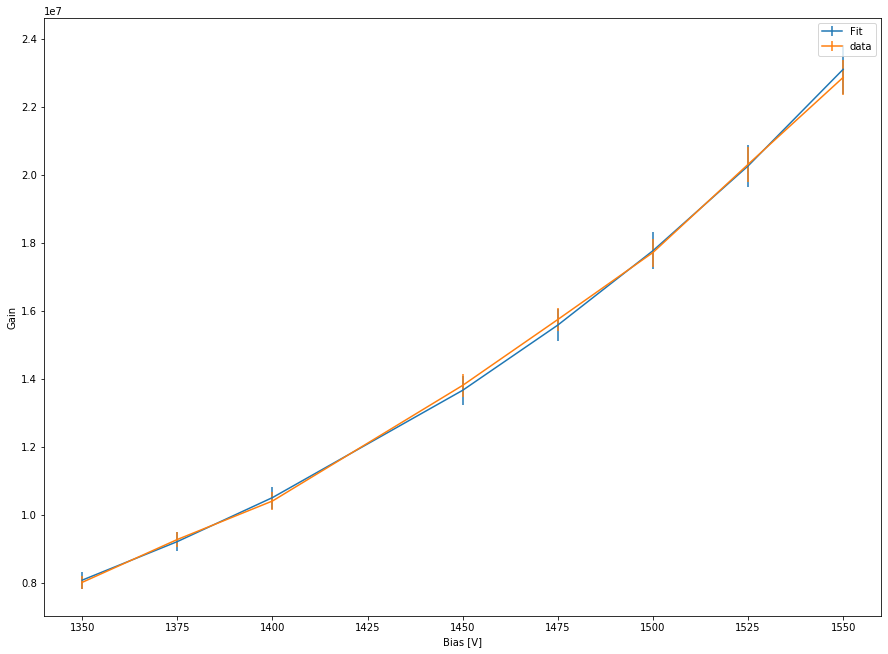

In [10]:
points = np.exp(fitQ[1] * np.array(Gains) + fitQ[0])
pointerr = np.sqrt(np.square(fitErr[1]/fitQ[1])+np.square(fitErr[0]/fitQ[0]))*points
plt.errorbar(Gains,points,yerr=pointerr,label='Fit')
plt.errorbar(Gains,QSPE/qe,label='data',yerr = QErr/qe)
plt.plot()
#plt.yscale('log')
#plt.xlim(-2,10)
plt.xlabel('Bias [V]')
plt.ylabel('Gain')
plt.legend()
plt.savefig(pmt+"_GainCurve.png")


## 